In [87]:


import os
import json
from typing import List

import pandas

def collect_stat(benchmark_result_dir:str, csv_path=None):
    if csv_path is None:
        csv_path = os.path.join(benchmark_result_dir, "summary.csv")
    
    all_data = []
    # Loop through the items in the directory
    for item in os.listdir(benchmark_result_dir):
        subdir_full_path = os.path.join(benchmark_result_dir, item)
        # Check if the item is a subdirectory
        if not (item.startswith('nreqs') and os.path.isdir(subdir_full_path)):
            print(f'skipping {item}')
            continue
        benchmark_json = os.path.join(subdir_full_path, 'benchmark.json')
        if not (os.path.isfile(benchmark_json)):
            print(f'skipping {item}')
            continue
        # Parse dir name to configs 
        configs = {}
        pairs = item.split('.')
        for pair in pairs:
            key, value = pair.split('_')
            try:
                value = int(value)
            except ValueError:
                pass
            # Add the key-value pair to the dictionary
            configs[key] = value
        # Read the benchmark result
        with open(benchmark_json) as file:
            metrics = json.load(file)
        
        # Read the profile result and analyze
        with open(os.path.join(subdir_full_path, 'profile.json')) as file:
            profile = json.load(file)
        def get_event(fuzzy_event_name:str, events:List[dict]):
            for e in events:
                if fuzzy_event_name in e["name"]:
                    return e
            return None
        # TODO: there is a reduce kernel in PagedAttentionV2 
        event2fuzzyid={
            "cache_op": "vllm::reshape_and_cache_kernel",
            "attn_usr": "vllm::paged_attention",
            "attn_sys": "flash_fwd",
            "relay_fusion": "_relay_fuse_kernel"
        }
        durations = {}
        for event_name, fuzzy_id in event2fuzzyid.items():
            event = get_event(fuzzy_id, events=profile["traceEvents"])
            if event is not None:
            # print(item, event_name)
                durations[event_name] = event['dur']
            else:
                assert configs['relay'] == "false"
                durations[event_name] = 0
        durations['others'] = metrics['Lantency (us)'] - sum(durations.values())

        # print(configs, metrics, durations)
        all_data.append({**configs, **metrics, **durations})

    df = pandas.DataFrame(all_data)
    df.to_csv(csv_path, index=False)
    
    return df

In [88]:
import matplotlib.pyplot as plt
import numpy as np
from typing import Iterable, Union, List, Dict

def plot_multi_barchart(group_ids:Union[List[int], List[str]],
                        data_dict:Dict[str, Iterable], ax:plt.Axes=None,
                        put_text_on_bars:bool=False):
    ngrps = len(group_ids)
    nbars_per_grp = len(data_dict)
    bar_width = 1. / (nbars_per_grp + 1)
    # opacity = 0.8
    opacity = 1.0

    leftmost = np.arange(ngrps) - (nbars_per_grp*bar_width / 2)

    if ax is None:
        _, ax = plt.subplots()

    for idx, (name, data) in enumerate(data_dict.items()):
        assert len(data) == ngrps
        center_offset_to_leftmost = bar_width / 2 + bar_width*idx
        bars = plt.bar(
            leftmost + center_offset_to_leftmost , # center of the bars
            data, # heights of the bars
            bar_width,
            alpha=opacity,
            label=name
        )
        if put_text_on_bars:
            for i in range(ngrps):
                # print(data[i])
                plt.text(leftmost[i]+center_offset_to_leftmost, data[i], f'{data[i]:.1f}', ha='center', size='x-small')
    
    ax.set_xticks(np.arange(ngrps), group_ids)
    
    return ax

In [89]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def plot_figure(csv_path:str, nreqs_plot:int=32, ctxlen_plot=128, metric_plot='Lantency (us)',
                ftype='bar', y_lim=None, prefixlens_plot=(64, 128, 256, 512, 1024)):
    assert ftype in {'line', 'bar'}
    line_styles = ['-o', '-D', '->']
    df = pd.read_csv(csv_path)
    condition = (df['nreqs']==nreqs_plot) & (df['ctxlen']==ctxlen_plot)
    condition_dict = { 
        'RelayAttention (ours)' : condition & (df['relay']==True),
        'PagedAttention': condition & (df['relay']==False) 
    }
    
    # print(df['relay'])
    data_dict = {}
    for name, cond in condition_dict.items():
        # print(df)
        # print(df['reqrate'])
        view = df[cond].sort_values('prefixlen')
        # print(view)
        x = view['prefixlen'].to_numpy(dtype=np.int32)
        y = view[metric_plot].to_numpy(dtype=np.float32)
        if prefixlens_plot is not None:
            mask = np.in1d(x, prefixlens_plot)
            x = x[mask]
            y = y[mask]
        data_dict[name] = (x, y)
    
    # print(x)
    
    try:
        plt_context = plt.style.context(['light', 'grid'])
        with plt_context:
            pass
    except:
        import contextlib
        plt_context = contextlib.nullcontext()
    
    with plt_context:
        figure, ax = plt.subplots()
        if ftype == 'line':
            for idx, (label, data) in enumerate(data_dict.items()):
                x, y = data
                ax.plot(x, y, line_styles[idx], label=label)
            if y_lim:
                ax.set_ylim(y_lim)
        else:
            bar_dict = {k:v for k, (_, v) in data_dict.items()}
            group_ids = list(data_dict.values())[0][0]
            plot_multi_barchart(group_ids=group_ids, data_dict=bar_dict, ax=ax)
        
        ax.set_ylabel('Latency (us)')
        ax.set_xlabel('System Prompt Length (#toks)')
        # ax.set_title(title='Latency vs. System Prompt Length')
        ax.legend()
    plt.tight_layout()
    plt.show()

In [90]:
def legacy_plot(csv_path,  nreqs_plot:int=32, ctxlen_plot=128):
    df = pd.read_csv(csv_path)
    condition = (df['nreqs']==nreqs_plot) & (df['ctxlen']==ctxlen_plot) & (df['prefixlen'] <= 1024)
    latency_relay = df[condition & (df['relay'] == 'true')].sort_values('prefixlen')
    latency_norelay = df[condition & (df['relay'] == 'false')].sort_values('prefixlen')
    df_new = pandas.DataFrame(
        data={'PagedAttention': latency_norelay['Lantency (us)'].to_numpy(), 
              'RelayAttention (ours)': latency_relay['Lantency (us)'].to_numpy()},
        index=latency_relay['prefixlen'].to_numpy()
    )
    figsize=(8, 6)
    plt.rcParams.update({'font.size': 12, 'font.serif': 'Times New Roman', 'axes.linewidth': 1})
    
    try:
        plt_context = plt.style.context(['light', 'grid'])
        with plt_context:
            pass
    except:
        import contextlib
        plt_context = contextlib.nullcontext()

    # save_path=os.path.join(bench_exps_dir, f'teaser_bs{nreqs_plot}ctxlen{ctxlen_plot}.svg')
    with plt_context:
        ax = df_new.plot.bar(
                xlabel='System Prompt Length (#tokens)',
                ylabel='Latency (us)',
                title='Latency vs. System Prompt Length',
                width=0.7,
                rot=0)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
    plt.tight_layout()
    # plt.savefig(save_path, dpi=300)
    plt.show()

skipping nreqs_128.ctxlen_128.prefixlen_16384.relay_false
skipping nreqs_128.ctxlen_256.prefixlen_16384.relay_false


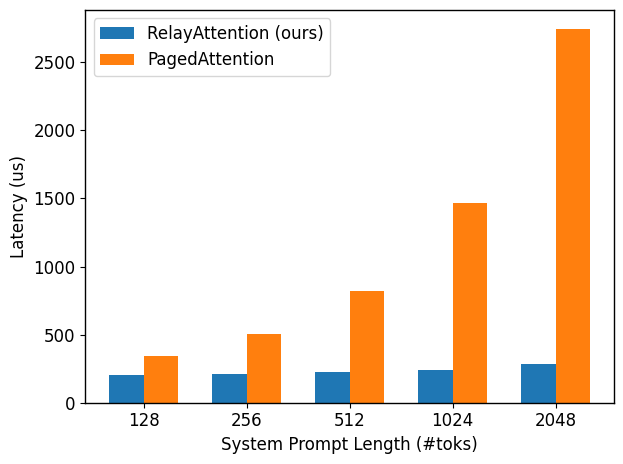

In [91]:
bench='relay_op'
exp_root = f'../outputs/{bench}'

csv_root = f'../stat/{bench}'
os.makedirs(csv_root, exist_ok=True)

collect = True

if collect:
    for gpu in os.listdir(exp_root):
        gpu_dir = os.path.join(exp_root, gpu)
        benchmark_result_dir = gpu_dir
        csv_path = os.path.join(csv_root, f'{gpu}.csv')
        collect_stat(benchmark_result_dir, csv_path=csv_path)

for file in os.listdir(csv_root):
    if file.endswith('.csv'):
        gpu, _ = file.split('.')
        csv_path = os.path.join(csv_root,file)
        plot_figure(csv_path, ftype='bar', prefixlens_plot=(128, 256, 512, 1024, 2048))
        # legacy_plot(csv_path)

In [92]:
# import os
# import os.path as osp
# from matplotlib import pyplot as plt
# import numpy as np

# bench_root = '../outputs/relay_op'
# gpus = os.listdir(bench_root)

# for gpu in gpus:
#     bench_exps_dir = osp.join(bench_root, gpu)
#     df = summarize_exps_to_csv(bench_exps_dir)
#     for nreqs_plot in df['nreqs'].unique():
#         for ctxlen_plot in df['ctxlen'].unique():
#             condition = (df['nreqs']==nreqs_plot) & (df['ctxlen']==ctxlen_plot)
#             latency_relay = df[condition & (df['relay'] == 'true')].sort_values('prefixlen')
#             latency_norelay = df[condition & (df['relay'] == 'false')].sort_values('prefixlen')
#             df_new = pandas.DataFrame(
#                 data={'PagedAttention': latency_norelay['Lantency (us)'].to_numpy(), 
#                       'RelayAttention (ours)': latency_relay['Lantency (us)'].to_numpy()},
#                 index=latency_relay['prefixlen'].to_numpy()
#             )
#             figsize=(8, 6)
#             plt.rcParams.update({'font.size': 12, 'font.serif': 'Times New Roman', 'axes.linewidth': 1})
#             save_path=os.path.join(bench_exps_dir, f'teaser_bs{nreqs_plot}ctxlen{ctxlen_plot}.svg')
#             with plt.style.context(['light']):
#                 ax = df_new.plot.bar(
#                         xlabel='System Prompt Length (#tokens)',
#                         ylabel='Latency (us)',
#                         title='Latency vs. System Prompt Length',
#                         width=0.7,
#                         rot=0)
#                 ax.spines['right'].set_visible(False)
#                 ax.spines['top'].set_visible(False)
#             plt.tight_layout()
#             plt.savefig(save_path, dpi=300)
#             plt.show()